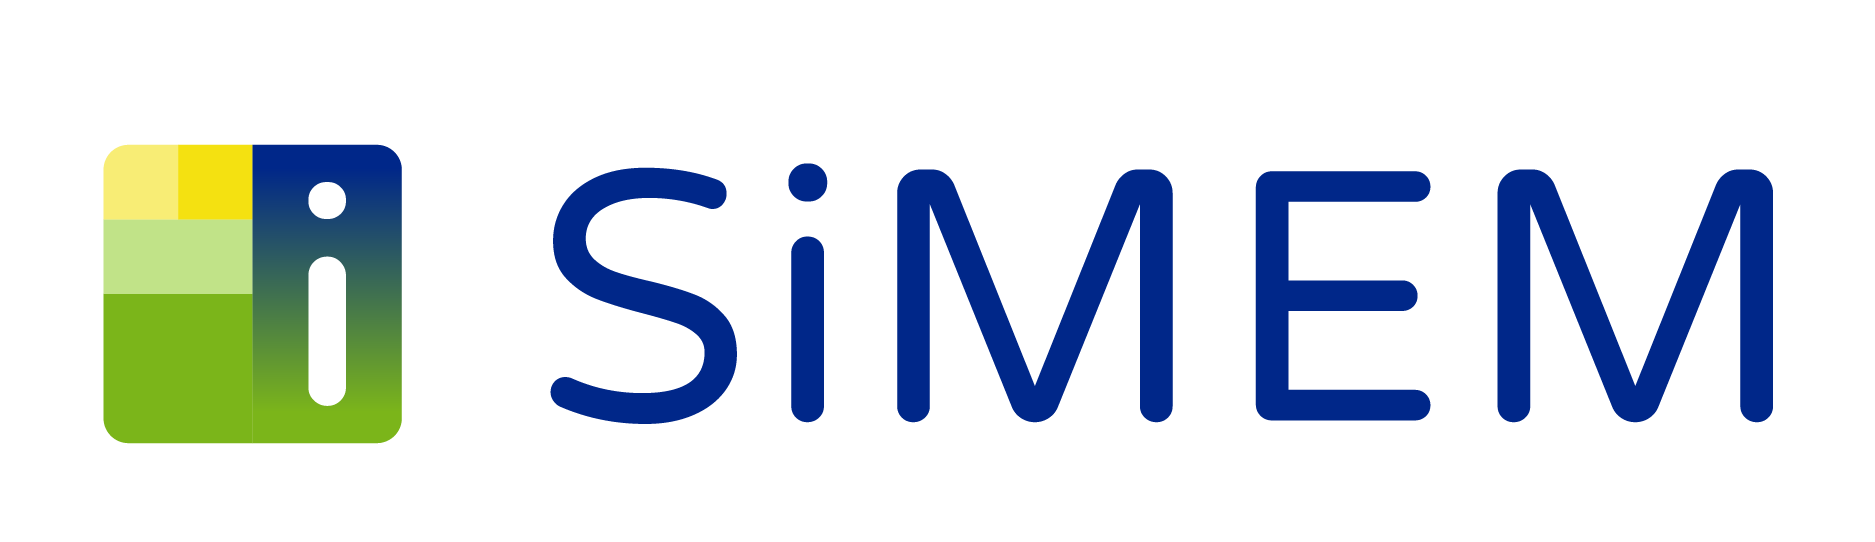

[SiMEM](https://www.simem.co/)

## Objetivos de este Notebook

* Explicar cómo se puede consultar el catálogo de conjuntos de datos que se publican en SiMEM.
* Explicar cómo consultar la información de un conjunto de datos determinado.
* Demostrar cómo hacer filtros especializados en un conjunto de datos determinado.

### Carga del simem PyDataSimem

En la siguiente celda se importa el objeto PyDataSimem, que contiene el método para consultar los conjuntos de datos de SiMEM. Si la librería no se encuentra instalada en el ambiente, se puede utilizar el código comentado en la celda para realizar la instalación. 

In [1]:
import sys
import os
# !{sys.executable} -m pip install pydataxm
from pydataxm.pydatasimem import ReadSIMEM, CatalogSIMEM

### Importacion de librerías

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates

Matplotlib is building the font cache; this may take a moment.


### Obtener el catálogo de conjuntos de datos

El catálogo de conjuntos de datos de SiMEM también es un conjunto de datos, con DatasetID 'e007fb'.

Utilizando el objeto de catálogo de la librería se puede consultar toda la información necesaria. Solo es necesario inicializarlo y tendrá toda la información en los atributos del objeto.

In [5]:
catalogo = CatalogSIMEM(catalog_type='Datasets')

In [6]:
df_catalogo = catalogo.get_data()
df_catalogo.head()

,idDataset,nombreConjuntoDatos,fechaPublicacion,fechaActualizacion,inicioDato,finDato,fechaDescarga,urlConexionAPI,urlConjuntoDatos,tipoPublicacion
0,ADE905,Panorama energético Corto Plazo Generación,2023-11-28T12:07:03.03,2024-09-10T13:42:48.23,2023-10-02T00:00:00,2024-09-08T00:00:00,2024-09-17T13:59:29.887,https://www.simem.co/backend-files/api/PublicD...,https://www.simem.co/datadetail/ade905f7-cb05-...,Público
1,a704ee,Datos soporte del proceso de liquidación por C...,2023-09-28T21:28:06.433,2024-11-14T11:21:27.3,2017-12-01T00:00:00,2024-10-01T00:00:00,2024-10-17T14:26:04.333,https://www.simem.co/backend-files/api/PublicD...,https://www.simem.co/datadetail/a704eef3-ca1c-...,Público
2,d808d4,Energía de Referencia para el Mercado Secundario,2023-09-29T11:01:54.317,2024-11-13T11:38:45.327,2018-12-01T00:00:00,2050-11-30T00:00:00,2024-10-29T10:41:42.083,https://www.simem.co/backend-files/api/PublicD...,https://www.simem.co/datadetail/d808d43d-e3da-...,Público
3,2106b8,Precios y estadísticas de los contratos de con...,2023-09-30T10:35:01.19,2024-11-05T06:23:54.363,2020-10-01T00:00:00,2024-10-01T00:00:00,2024-10-29T23:11:56.05,https://www.simem.co/backend-files/api/PublicD...,https://www.simem.co/datadetail/99686983-57a4-...,Público
4,F3A83B,Estadísticas de contratos de Demanda Desconect...,2023-09-30T11:09:06.763,2024-11-14T08:12:47.077,2022-12-01T00:00:00,2024-11-01T00:00:00,2024-11-12T09:37:10.313,https://www.simem.co/backend-files/api/PublicD...,https://www.simem.co/datadetail/f3a83baa-a370-...,Público


Aquí se obtienen todos los conjuntos de datos disponibles en SiMEM, las columnas se leen de la siguiente manera:
 
* **idDataset**: Identificador único del conjunto de datos, es el que se utiliza en el simem PyDataSimem para consultar la información.
* **nombreConjuntoDatos**: Nombre con el que se encuentra el conjunto de datos en el portal.
* **fechaPublicacion**: Indica desde cuando existe el el conjunto de datos en SIMEM
* **fechaActualizacion**: Indica la ultima vez que se actualizó el conjunto de datos
* **inicioDato**: Indica desde qué fecha contiene información el conjunto de datos
* **finDato**: Indica hasta cuando contiene información el conjunto de datos
* **fechaDescarga**: Indica la fecha y hora de la ultima descarga del conjunto de datos
* **urlConexionAPI**: URL para la conexión a la API
* **urlConjuntoDatos**: URL para la conexión en el portal SIMEM
* **tipoPublicacion**: 	Privacidad del conjunto de datos

### Consultar información de un conjunto de datos

Para el ejemplo, se desea consultar la información de la Generación Real del SIN entre la fecha 2024-04-01 y la fecha 2024-04-07. Para esto, buscamos en el catálogo de datos el Dataset ID correspondiente

In [27]:
df_catalogo.query("nombreConjuntoDatos.str.contains('Generación Real')")

,idDataset,nombreConjuntoDatos,fechaPublicacion,fechaActualizacion,inicioDato,finDato,fechaDescarga,urlConexionAPI,urlConjuntoDatos,tipoPublicacion
208,E17D25,Generación Real y Programada en las Plantas de...,2023-09-29T10:59:40.38,2024-05-09T08:14:57.693,2013-01-01T00:00:00,2024-05-07T00:00:00,2024-04-26T17:46:58.05,https://www.simem.co/backend-files/api/PublicD...,https://www.simem.co/datadetail/e17d259d-ffba-...,Público


Ahora, se definen los parámetros de entrada y se hace la búsqueda de la información.

In [8]:
dataset_id = 'E17D25'
fecha_inicio = '2024-04-01'
fecha_fin = '2024-04-30'
simem = ReadSIMEM(dataset_id, fecha_inicio, fecha_fin)

In [9]:
df_genreal = simem.main()
df_genreal.head(10)

,Fecha,CodigoPlanta,TipoGeneracion,TipoClasificacion,TipoDespachoRecurso,GeneracionRealEstimada,GeneracionProgramadaDespacho,GeneracionProgramadaRedespacho
0,2024-04-30,3HLD,Solar,Solar,No Despachado Centralmente,43896.92,70840.0,70840.0
1,2024-04-30,3GVI,Solar,Solar,No Despachado Centralmente,155235.44,6000.0,6000.0
2,2024-04-30,3K6T,Solar,Solar,No Despachado Centralmente,57742.14,58390.0,58390.0
3,2024-04-30,3J4R,Solar,Solar,No Despachado Centralmente,72670.67,78550.0,78550.0
4,2024-04-30,3IS2,Solar,Solar,No Despachado Centralmente,15482.22,12900.0,12900.0
5,2024-04-30,3J2H,Solar,Solar,No Despachado Centralmente,50692.80,75230.0,75230.0
6,2024-04-30,3HF7,Solar,Solar,No Despachado Centralmente,152107.45,139000.0,139000.0
7,2024-04-30,3CSH,Solar,Solar,No Despachado Centralmente,53915.81,46790.0,46790.0
8,2024-04-30,3C3Z,Solar,Solar,No Despachado Centralmente,152509.45,141000.0,141000.0
9,2024-04-30,3EBN,Solar,Solar,No Despachado Centralmente,69994.08,17000.0,17000.0


### Analizar la información consultada

De acuerdo con la información que entrega el conjunto de datos de generación real, es posible obtener información, por ejemplo, de cuánto fue la generación real por tipo de generación para cada día de la consulta.

In [10]:
df_genreal_tipo = df_genreal.groupby(['Fecha','TipoGeneracion'])['GeneracionRealEstimada'].sum().reset_index()
millon = 1000000
df_genreal_tipo['GeneracionRealEstimada'] = df_genreal_tipo['GeneracionRealEstimada'].div(millon)
df_genreal_tipo = df_genreal_tipo.pivot_table(columns='TipoGeneracion', index='Fecha', values='GeneracionRealEstimada', fill_value=0).reset_index()
df_genreal_tipo['Fecha'] = pd.to_datetime(df_genreal_tipo['Fecha'], format='%Y-%m-%d')
df_genreal_tipo.head()

TipoGeneracion,Fecha,Cogenerador,Eolica,Hidraulica,Solar,Termica
0,2024-04-01,2.214651,0.433633,117.223750,9.861246,102.354904
1,2024-04-02,2.160171,0.443939,117.813511,7.857762,101.570386
2,2024-04-03,2.358129,0.416975,117.142970,7.001703,104.479538
3,2024-04-04,2.222087,0.369173,117.444236,5.762751,104.918669
4,2024-04-05,2.050047,0.386227,123.198462,9.090898,102.559779


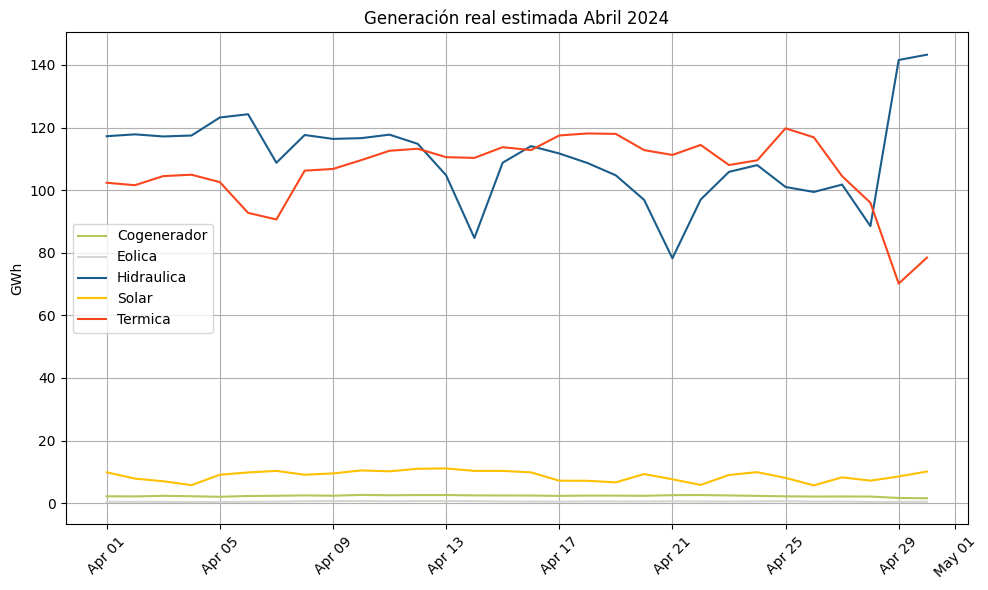

In [11]:
tipo_generacion = list(df_genreal_tipo.drop(columns='Fecha').columns)
colores = {
    'Cogenerador' : '#B5C759',
    'Eolica' : '#D5D6D2',
    'Hidraulica' : '#1A5C8A',
    'Solar' : '#FFC000',
    'Termica' : '#F9461C'
}
def graficar_precios() -> None:

    plt.figure(figsize=(10, 6))
   
    for column in tipo_generacion:
        plt.plot(df_genreal_tipo['Fecha'], df_genreal_tipo[column], color=colores[column], label=column)

    plt.ylabel('GWh')
    plt.title('Generación real estimada Abril 2024')
    plt.legend()
    plt.grid(which='both', axis='both')

    plt.gca().xaxis.set_major_formatter(mpl_dates.DateFormatter('%b %d'))
    
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

graficar_precios()
